<a href="https://colab.research.google.com/github/hardscrey/superstore_marketing_analis/blob/main/Portfolio3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Аналитика продаж и A/B-тест скидок (Superstore)
**Цель проекта:**
- Провести маркетинговый анализ продаж (категории, сезонность, KPI).
- Выполнить RFM-анализ для сегментации клиентов.
- Провести полноценный A/B-тест по влиянию скидок `Discount` на `Profit` с подробными этапами, контролем ковариат и рекомендациями.

**Структура ноутбука:**

0. Установка зависимостей и импорты
1. Параметры и загрузка данных
2. Предобработка
3. Feature Engineering
4. EDA и маркетинговая аналитика
5. Сезонность и тренды
5. KPI-аналитика
6. RFM-анализ
8. A/B-тест по скидкам
9. Общие выводы по проекту
> Все результаты сохраняются в папках `images/` и `results/` (они будут созданы автоматически).

# 0) Установка зависимостей и импорты

In [85]:
# Импорты и глобальные настройки
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, normaltest
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

In [86]:
# Настройки отображения
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,6)
pd.set_option('display.max_columns', 200)
RND = 42
np.random.seed(RND)

In [87]:
# Создаём папки для артефактов
os.makedirs('images', exist_ok=True)
os.makedirs('results', exist_ok=True)

# 1) Параметры и загрузка данных

In [88]:
# Укажите путь к локальному CSV (загрузите файл в Colab или поместите рядом с .ipynb)
DATA_PATH = 'Sample - Superstore.csv'

In [89]:
df = pd.read_csv(DATA_PATH, parse_dates=['Order Date','Ship Date'], encoding='ISO-8859-1')
print('Размер датасета:', df.shape)
display(df.head(3))

Размер датасета: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


Описание фич:

`Row ID` - Unique ID for each row.

`Order ID` - Unique Order ID for each Customer.

`Order Date` - Order Date of the product.

`Ship Date` - Shipping Date of the Product.

`Ship Mode`- Shipping Mode specified by the Customer.

`Customer ID` - Unique ID to identify each Customer.

`Customer Name` - Name of the Customer.

`Segment` - The segment where the Customer belongs.

`Country` - Country of residence of the Customer.

`City` - City of residence of of the Customer.

`State` - State of residence of the Customer.

`Postal` Code - Postal Code of every Customer.

`Region` - Region where the Customer belong.

`Product ID` - Unique ID of the Product.

`Category` - Category of the product ordered.

`Sub-Category` - Sub-Category of the product ordered.

`Product Name` - Name of the Product

`Sales` - Sales of the Product.

`Quantity` - Quantity of the Product.

`Discount` - Discount provided.

`Profit` - Profit/Loss incurred.



# 2) Предобработка: очистка, удаление лишних колонок, кодирование

In [90]:
# Краткая проверка
display(df.info())
display(df.describe(include='all').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

None

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Row ID,9994.0,NaN,NaN,NaN,4997.5,1.0,2499.25,4997.5,7495.75,9994.0,2885.163629
Order ID,9994,5009,CA-2017-100111,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Order Date,9994,NaN,NaN,NaN,2016-04-30 00:07:12.259355648,2014-01-03 00:00:00,2015-05-23 00:00:00,2016-06-26 00:00:00,2017-05-14 00:00:00,2017-12-30 00:00:00,NaN
Ship Date,9994,NaN,NaN,NaN,2016-05-03 23:06:58.571142912,2014-01-07 00:00:00,2015-05-27 00:00:00,2016-06-29 00:00:00,2017-05-18 00:00:00,2018-01-05 00:00:00,NaN
Ship Mode,9994,4,Standard Class,5968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer ID,9994,793,WB-21850,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer Name,9994,793,William Brown,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Segment,9994,3,Consumer,5191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Country,9994,1,United States,9994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,9994,531,New York City,915,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Проверим пропуски
df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


# 3) Feature Engineering
- `discount_flag` - бинарный флаг скидки
- `discount_group` - распределение по уровням скидок
- `AOV` - средняя цена за единицу
- `margin` - маржинальность (в долях)
- `order_month` - месяц заказа
- `order_d` - день недели заказа

In [92]:
# Добавим бинарный флаг скидки
df['discount_flag'] = (df['Discount'] > 0).astype(int)

In [93]:
# Уровни скидок
bins = [-0.01, 0.0, 0.16, 0.32, 0.64, 1.0]
labels = ['No Discount','Low (0-16%)','Medium (16-32%)','High (32-64%)','Very High (>64%)']
df['discount_group'] = pd.cut(df['Discount'], bins=bins, labels=labels)

In [94]:
# KPI
df['AOV'] = df['Sales'] / df['Quantity'].replace(0, np.nan)   # средняя цена
df['margin'] = df['Profit'] / df['Sales'].replace(0, np.nan)  # маржинальность

In [95]:
# Извлечём год/месяц/день недели
df['order_month'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()
df['order_d'] = df['Order Date'].dt.day_name()

In [96]:
print('Признаки добавлены. Пример:')
display(df[['Order Date','order_month','order_d','discount_group','AOV','margin']].head())

Признаки добавлены. Пример:


,Order Date,order_month,order_d,discount_group,AOV,margin
0,2016-11-08,2016-11-01,Tuesday,No Discount,130.9800,0.1600
1,2016-11-08,2016-11-01,Tuesday,No Discount,243.9800,0.3000
2,2016-06-12,2016-06-01,Sunday,No Discount,7.3100,0.4700
3,2015-10-11,2015-10-01,Sunday,High (32-64%),191.5155,-0.4000
4,2015-10-11,2015-10-01,Sunday,Medium (16-32%),11.1840,0.1125


# 4) EDA и маркетинговая аналитика


Определим топ в каждом показателе по прибыли

In [97]:
# Топ по категориям
top_cat = df.groupby('Category').agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index()
top_cat.to_csv('results/top_categories.csv', index=False)
display(top_cat)

,Category,total_sales,avg_sales,total_profit,orders,avg_discount
0,Technology,836154.0330,452.709276,145454.9481,1847,0.132323
1,Office Supplies,719047.0320,119.324101,122490.8008,6026,0.157285
2,Furniture,741999.7953,349.834887,18451.2728,2121,0.173923


Категория технологии приносит больше всего прибыли, это обуславливается высокой стоимостью товаров и невысокими скидками. Офисные принадлежности немного уступают в прибыли, при этом количество заказов весьма велико, а цены на товары низки. Мебель приносит меньше всего прибыли(в разы), возможно это обусловлено высокими скидками.

In [98]:
# Топ по суб-категориям
top_scat = df.groupby(['Sub-Category', 'Category']).agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index().head(5)
display(top_scat)

,Sub-Category,Category,total_sales,avg_sales,total_profit,orders,avg_discount
0,Copiers,Technology,149528.030,2198.941618,55617.8249,68,0.161765
1,Phones,Technology,330007.054,371.211534,44515.7306,889,0.154556
2,Accessories,Technology,167380.318,215.974604,41936.6357,775,0.078452
3,Paper,Office Supplies,78479.206,57.284092,34053.5693,1370,0.074891
4,Binders,Office Supplies,203412.733,133.560560,30221.7633,1523,0.372292


Первые места достались суб катаегориям из категории Технологии

In [99]:
# Топ 5 продуктов по прибыли
top_products = df.groupby(['Product Name', 'Sub-Category', 'Category']).agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index().head(5)
top_products.to_csv('results/top_products.csv', index=False)
display(top_products)

,Product Name,Sub-Category,Category,total_sales,avg_sales,total_profit,orders,avg_discount
0,Canon imageCLASS 2200 Advanced Copier,Copiers,Technology,61599.824,12319.96480,25199.9280,5,0.120000
1,Fellowes PB500 Electric Punch Plastic Comb Bin...,Binders,Office Supplies,27453.384,2745.33840,7753.0390,10,0.240000
2,Hewlett Packard LaserJet 3310 Copier,Copiers,Technology,18839.686,2354.96075,6983.8836,8,0.200000
3,Canon PC1060 Personal Laser Copier,Copiers,Technology,11619.834,2904.95850,4570.9347,4,0.150000
4,HP Designjet T520 Inkjet Large Format Printer ...,Machines,Technology,18374.895,6124.96500,4094.9766,3,0.166667


В топе находятся продукты с высокой стоимостью и небольшим количеством заказов

In [100]:
# Топ по сегментам
top_seg = df.groupby('Segment').agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index()
display(top_seg)

,Segment,total_sales,avg_sales,total_profit,orders,avg_discount
0,Consumer,1.161401e+06,223.733644,134119.2092,5191,0.158141
1,Corporate,7.061464e+05,233.823300,91979.1340,3020,0.158228
2,Home Office,4.296531e+05,240.972041,60298.6785,1783,0.147128


Самый прибыльный сегмент - это частные лица, у них наибольшее число заказов, при этом средняя стоимость заказов у всех сегментов почти равна

In [101]:
# Топ по регионам
top_reg = df.groupby('Region').agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index()
display(top_reg)

,Region,total_sales,avg_sales,total_profit,orders,avg_discount
0,West,725457.8245,226.493233,108418.4489,3203,0.109335
1,East,678781.2400,238.336110,91522.7800,2848,0.145365
2,South,391721.9050,241.803645,46749.4303,1620,0.147253
3,Central,501239.8908,215.772661,39706.3625,2323,0.240353


При приблизительно равных средних стоимостях, наибольшее влияние на прибыль оказали количкество заказов и средняя скидка

In [102]:
# Топ 5 штатов по прибыли
top_st = df.groupby(['State','Region']).agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index().head(5)
display(top_st)

,State,Region,total_sales,avg_sales,total_profit,orders,avg_discount
0,California,West,457687.6315,228.729451,76381.3871,2001,0.072764
1,New York,East,310876.2710,275.599531,74038.5486,1128,0.055319
2,Washington,West,138641.2700,273.994605,33402.6517,506,0.064032
3,Michigan,Central,76269.6140,299.096525,24463.1876,255,0.007059
4,Virginia,South,70636.7200,315.342500,18597.9504,224,0.000000


Средние стоимости и скидки не сильно отличаются, однако количество заказов повлияло на распределение топа

In [103]:
# Топ 5 городов по прибыли
top_ci = df.groupby(['City','State','Region']).agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index().head(5)
display(top_ci)

,City,State,Region,total_sales,avg_sales,total_profit,orders,avg_discount
0,New York City,New York,East,256368.161,280.183783,62036.9837,915,0.056175
1,Los Angeles,California,West,175851.341,235.410095,30440.7579,747,0.074297
2,Seattle,Washington,West,119540.742,279.300799,29156.0967,428,0.064953
3,San Francisco,California,West,112669.092,220.919788,17507.3854,510,0.066667
4,Detroit,Michigan,Central,42446.944,369.103861,13181.7908,115,0.006957


Нью-Йорк с боьлшим отрываом занимает 1 местоблагодаря высоким показателям во всех метриках

Анализ географического распределения ключевых показателей эффективности показывает, что:

Такие штаты, как Калифорния, Нью-Йорк и Вашингтон являются лидерами по показателям общей прибыли.

Наибольший вклад в общую прибыль вносят такие регионы, как Западный и Восточный.
Такие города, как Нью-Йорк, Лос Анджелес, Сиэтл являются важными центрами получения прибыли.

В разных географических точках наблюдаются различия в средних объемах продаж, AOV и рентабельности, что указывает на потенциальные региональные или местные рыночные различия.

Также можно заключить что, в США есть 2 основных центра на Западе и Востоке - Лос Анджелес Калифорния и Нью-Йорк.

In [104]:
# Топ по классу доставки
top_del = df.groupby('Ship Mode').agg(
    total_sales=('Sales','sum'),
    avg_sales=('Sales','mean'),
    total_profit=('Profit','sum'),
    orders=('Row ID','count'),
    avg_discount=('Discount','mean')
).sort_values('total_profit', ascending=False).reset_index()
display(top_del)

,Ship Mode,total_sales,avg_sales,total_profit,orders,avg_discount
0,Standard Class,1.358216e+06,227.583067,164088.7875,5968,0.160023
1,Second Class,4.591936e+05,236.089239,57446.6354,1945,0.138895
2,First Class,3.514284e+05,228.497024,48969.8399,1538,0.164610
3,Same Day,1.283631e+05,236.396179,15891.7589,543,0.152394


Доставка стандартным классом пользуется наибольшей популярностью и обладает наименьшей средней стоимостью, чем обуславливается высокая прибыль

/tmp/ipython-input-789902889.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df['discount_group'].value_counts().reset_index(), x='discount_group', y='count', palette='coolwarm')


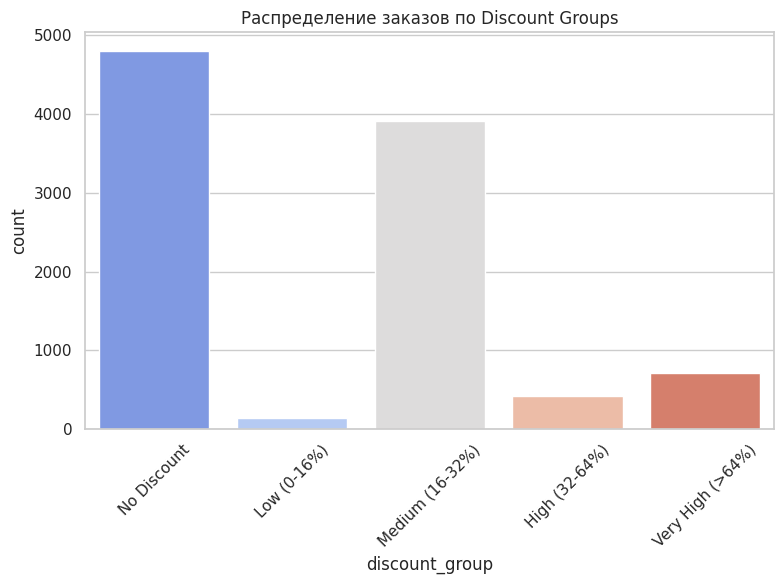

In [105]:
# Распределение по группам скидок
plt.figure()
sns.barplot(data=df['discount_group'].value_counts().reset_index(), x='discount_group', y='count', palette='coolwarm')
plt.title('Распределение заказов по Discount Groups')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('images/discount_group.png', dpi=200)
plt.show()

Среди заказов со скидкой преобладают средние скидки (16-32%)

/tmp/ipython-input-653230236.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  profit_by_discount_group = df.groupby('discount_group').agg(


,discount_group,mean_profit,median_profit,mean_sales,total_profit,total_sales,order_count
0,No Discount,66.900292,15.9952,226.742074,320987.6032,1.087908e+06,4798
1,Low (0-16%),71.562798,29.3488,561.149812,10448.1685,8.192787e+04,146
2,Medium (16-32%),19.835564,5.6376,225.598180,77576.8909,8.823145e+05,3911
3,High (32-64%),-123.518396,-46.7970,445.287406,-52001.2448,1.874660e+05,421
4,Very High (>64%),-98.348741,-11.4924,80.200610,-70614.3961,5.758404e+04,718


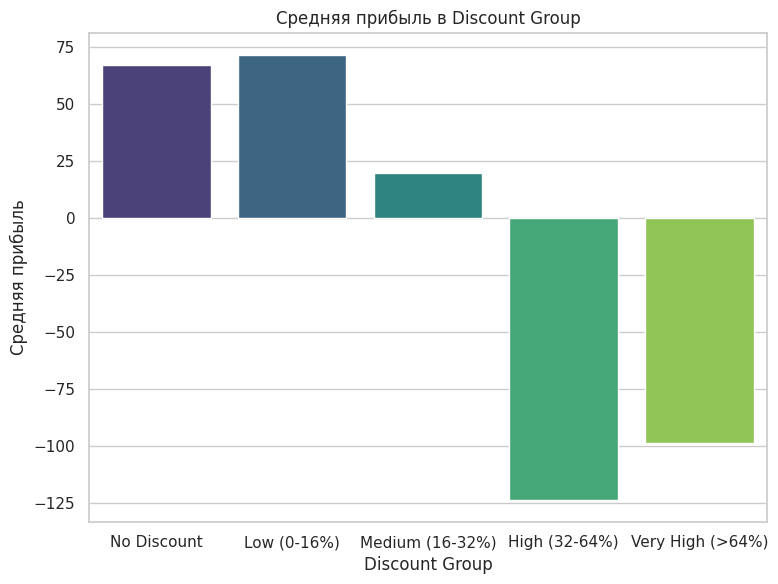

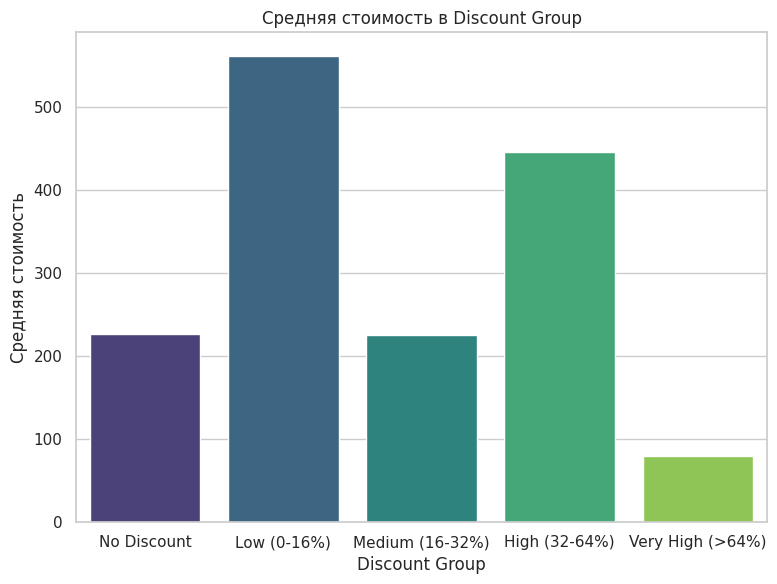

In [106]:
# Прибыль групп скидок
profit_by_discount_group = df.groupby('discount_group').agg(
    mean_profit=('Profit', 'mean'),
    median_profit=('Profit', 'median'),
    mean_sales=('Sales', 'mean'),
    total_profit=('Profit', 'sum'),
    total_sales=('Sales', 'sum'),
    order_count=('Row ID', 'count')
).reset_index()

order = ['No Discount', 'Low (0-16%)', 'Medium (16-32%)', 'High (32-64%)', 'Very High (>64%)']
profit_by_discount_group['discount_group'] = pd.Categorical(profit_by_discount_group['discount_group'], categories=order, ordered=True)
profit_by_discount_group = profit_by_discount_group.sort_values('discount_group')

display(profit_by_discount_group)

# Средняя прибыль групп скидок
plt.figure()
sns.barplot(data=profit_by_discount_group, x='discount_group', y='mean_profit', hue='discount_group', palette='viridis', legend=False)
plt.title('Средняя прибыль в Discount Group')
plt.xlabel('Discount Group')
plt.ylabel('Средняя прибыль')
plt.tight_layout()
plt.savefig('images/mean_profit_by_discount_group.png', dpi=200)
plt.show()

# Общая прибыль групп скидок
plt.figure()
sns.barplot(data=profit_by_discount_group, x='discount_group', y='mean_sales', hue='discount_group', palette='viridis', legend=False)
plt.title('Средняя стоимость в Discount Group')
plt.xlabel('Discount Group')
plt.ylabel('Средняя стоимость')
plt.tight_layout()
plt.savefig('images/mean_sales_by_discount_group.png', dpi=200)
plt.show()

Наибольшую суммарную прибыль показывают товары без скидок, однако товары с низкой скидкой имеют наибольшую среднюю прибыль но уступают в количестве заказов.

Среди групп скидок прибыль дают только заказы с низкой и средней скидкой, при этом заказы со срдней скидкой имееют среднюю стоимость как и товары без скидки и большое число заказов, но из за размера скидки приносят маленькую прибыль.

Товары с высокой и очень высокой скидками имеют небольшое количество заказов, средняя стоимость зваказов с очень высокой скидкой очень низка, скорее всего это недорогие товары, которые не пользуются спросам, и благодаря высоким скидкам компания хочет избавиться от них несмотря на отрицательную прибыль.
Заказы с высокой скидкой имеют довольно высокую среднюю стоимость, они тоже не пользуюжтся спросом, а из за высоких скидок приносят наибольшие убытки.

**Выводы по разделу EDA и маркетинговая аналитика**

На основе проведенного анализа были выявлены следующие ключевые моменты:

**Топ-категории, суб-категории и продукты:**
- Категории `Technology` и `Office Supplies` приносят наибольшую общую прибыль, в то время как `Furniture` имеет значительно меньшую прибыль, несмотря на сопоставимый объем продаж.
- Среди суб-категорий, `Copiers`, `Phones` и `Accessories` являются лидерами по прибыли. `Binders` имеют высокую среднюю скидку и при этом значительную общую прибыль, что может указывать на влияние скидок на объем продаж.
- Топ-продукты по прибыли подтверждают важность копиров и другой офисной техники.

**Географическое распределение:**
- Наибольший вклад в общую прибыль вносят штаты Калифорния и Нью-Йорк, а также Западный и Восточный регионы.
- Города Нью-Йорк, Лос-Анджелес и Сиэтл являются ключевыми центрами прибыли.
- Отмечаются региональные различия в среднем чеке (AOV) и маржинальности.

**Класс доставки:**
- `Standard Class` является наиболее часто используемым и приносит наибольшую общую прибыль, что ожидаемо ввиду объема. Средняя прибыль и средняя скидка по классам доставки относительно схожи.

**Распределение скидок:**
- Значительная часть заказов включает скидки, и их распределение по группам (Low, Medium, High, Very High) показывает, что скидки применяются на разных уровнях.


# 5) Сезонность и тренды

Определим наличие сезонности в стоимости и прибыли

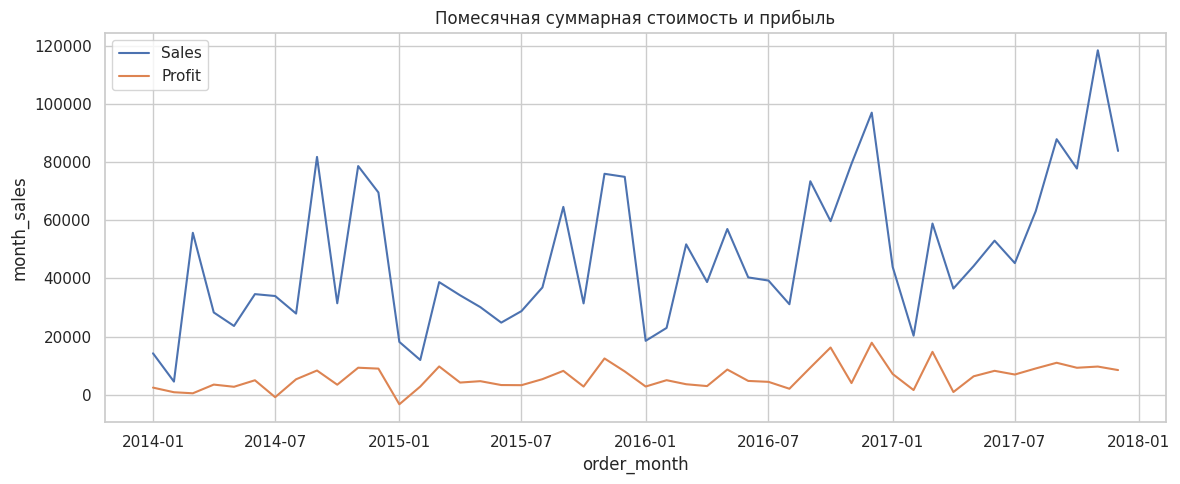

In [107]:
# Агрегация по месяцам
monthly = df.groupby('order_month').agg(month_sales=('Sales','sum'), month_profit=('Profit','sum')).reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly, x='order_month', y='month_sales', label='Sales')
sns.lineplot(data=monthly, x='order_month', y='month_profit', label='Profit')
plt.title('Помесячная суммарная стоимость и прибыль')
plt.tight_layout()
plt.savefig('images/monthly_sales_profit.png', dpi=200)
plt.show()

По графику видно наличие сезонности в стоимости заказов и рост стоисости со временем

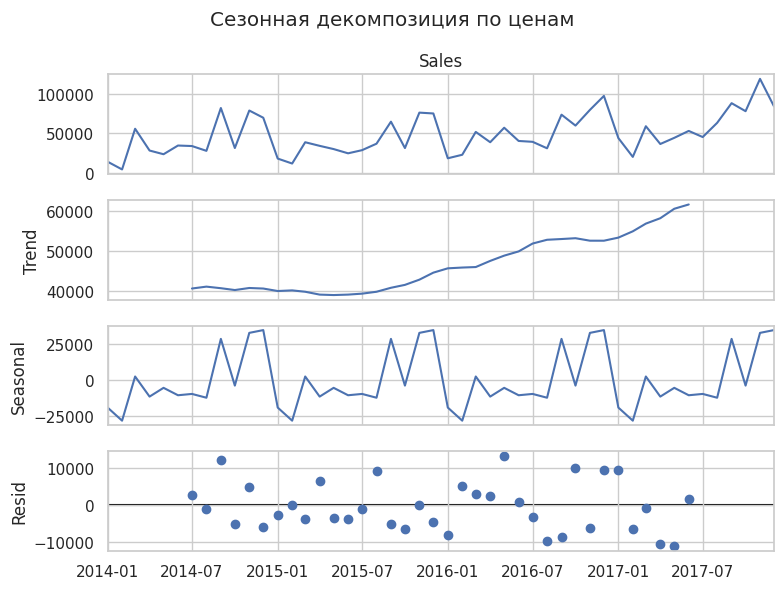

In [108]:
# Проведем сезонную декомпозицию
m_sales = df.groupby('order_month')['Sales'].sum()
result = seasonal_decompose(m_sales, model='additive', period=12)
result.plot()
plt.suptitle('Сезонная декомпозиция по ценам')
plt.tight_layout()
plt.savefig('images/seasonal_decompose_sales.png', dpi=200)
plt.show()

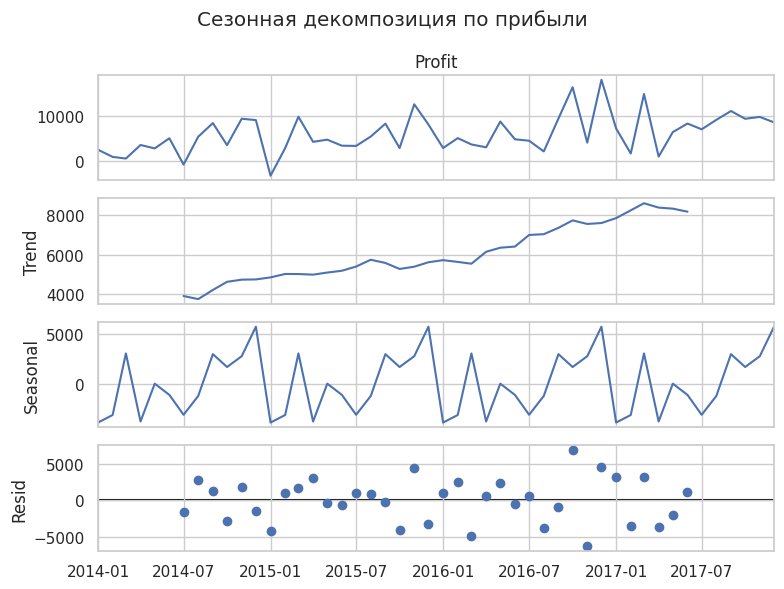

In [109]:
m_profit = df.groupby('order_month')['Profit'].sum()
result = seasonal_decompose(m_profit, model='additive', period=12)
result.plot()
plt.suptitle('Сезонная декомпозиция по прибыли')
plt.tight_layout()
plt.savefig('images/seasonal_decompose_profit.png', dpi=200)
plt.show()

Сезонная декомпозицию подтвердила наблюдения относительно стоимости, а также показала наличие сезонности и в прибыли, а также ее рост

Также для большей уверенности в выводах проведмтест Дики-Фуллера:

In [110]:
result = adfuller(monthly['month_sales'])
print('p-value:',result[1])

p-value: 0.00020180198458237758


Так как p-value меньше 0.05, то сезонность и тренд действительно есть

Проанализируем есть ли взаимосвязь между днем недели и продажами

/tmp/ipython-input-1746736900.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=d, x='order_d', y='count_orders', palette='coolwarm')


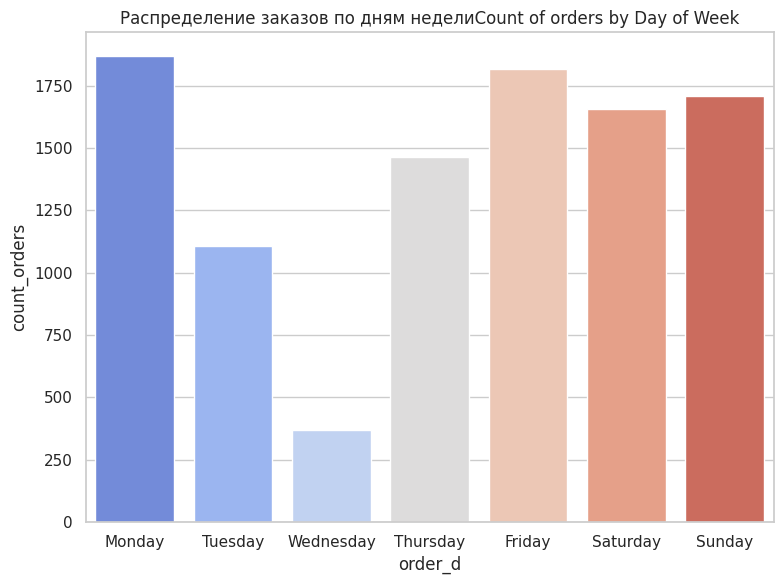

In [111]:
# День недели: Количество заказов
d = df.groupby('order_d').agg(count_orders=('Order ID','count')).reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()
plt.figure()
sns.barplot(data=d, x='order_d', y='count_orders', palette='coolwarm')
plt.title('Распределение заказов по дням неделиCount of orders by Day of Week')
plt.tight_layout()
plt.savefig('images/sales_by_d.png', dpi=200)
plt.show()

Количество заказов в среду значительно ниже, во вторник и четверг также наблюдаются просадки

/tmp/ipython-input-3480973788.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=d, x='order_d', y='mean_profit', palette='coolwarm')


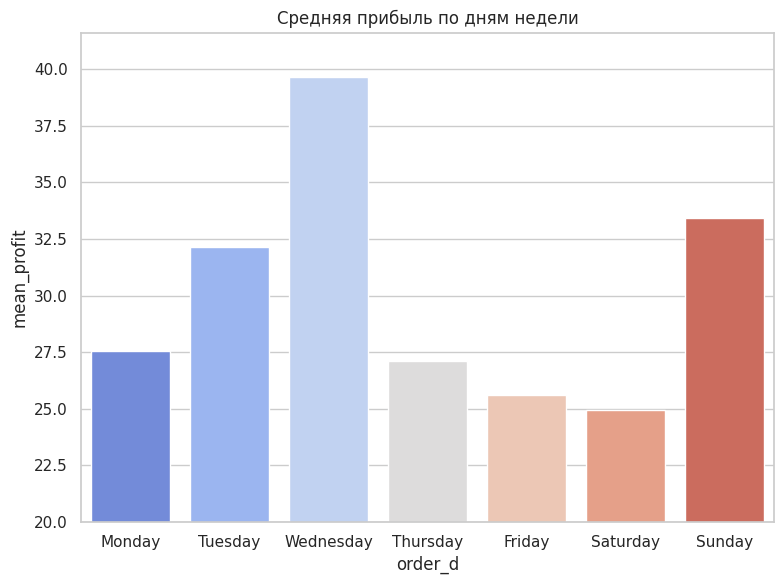

In [112]:
# День недели: Средняя прибыль
d = df.groupby('order_d').agg(mean_profit=('Profit','mean')).reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()
plt.figure()
sns.barplot(data=d, x='order_d', y='mean_profit', palette='coolwarm')
plt.title('Средняя прибыль по дням недели')
plt.ylim(20)
plt.tight_layout()
plt.savefig('images/mean_profit_by_d.png', dpi=200)
plt.show()

Наивысшуб прибыль показывают среда и воскресенье

/tmp/ipython-input-1498407855.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=d, x='order_d', y='mean_sales', palette='coolwarm')


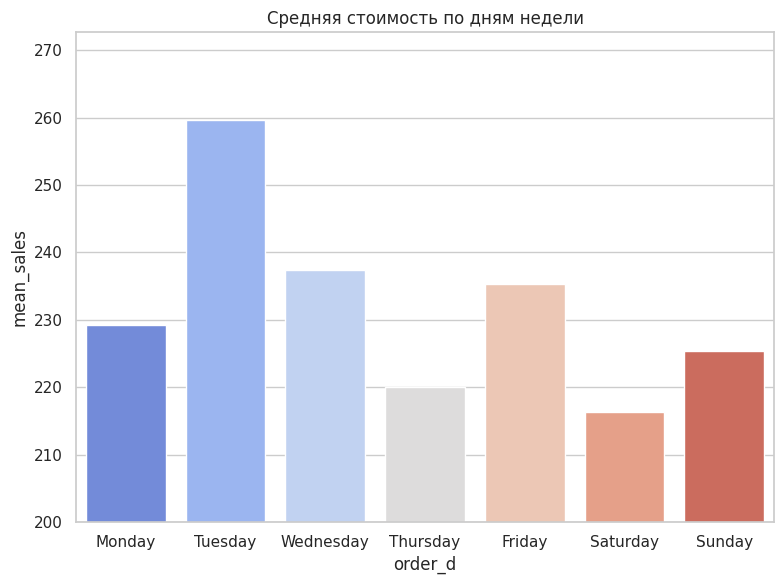

In [113]:
# День недели: средние продажи
d = df.groupby('order_d').agg(mean_sales=('Sales','mean')).reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()
plt.figure()
sns.barplot(data=d, x='order_d', y='mean_sales', palette='coolwarm')
plt.title('Средняя стоимость по дням недели')
plt.ylim(200)
plt.tight_layout()
plt.savefig('images/mean_sales_by_d.png', dpi=200)
plt.show()

Средняя стоимость заказов выше всего по вторникам

**Выводы по разделу Сезонность и тренды**

Анализ сезонности и трендов выявил следующее:

- Наблюдается четко выраженная **сезонность в продажах и прибыли**, с устойчивыми пиками в конце каждого года (особенно в **ноябре и декабре**). Это совпадает с периодом праздничных распродаж и может быть использовано для планирования маркетинговых кампаний и управления запасами.
- Присутствует общий **восходящий тренд в продажах и прибыли** на протяжении всего периода данных, что свидетельствует о росте бизнеса.
- Сезонная декомпозиция подтверждает наличие как **трендовой**, так и **сезонной компонент** в данных по продажам и прибыли.
- Анализ по дням недели показывает, что **количество заказов и средние продажи варьируются** в течение недели.

# 6) KPI-аналитика: AOV, маржа, средняя скидка

In [114]:
# KPI по категориям
kpi_cat = df.groupby('Category').agg(
    total_sales=('Sales','sum'),
    total_profit=('Profit','sum'),
    mean_discount=('Discount','mean'),
    mean_AOV=('AOV','mean'),
    mean_margin=('margin','mean')
).sort_values('total_profit', ascending=False)
kpi_cat.to_csv('results/kpi_by_category.csv', index=False)
display(kpi_cat)

,total_sales,total_profit,mean_discount,mean_AOV,mean_margin
Category,,,,,
Technology,836154.0330,145454.9481,0.132323,120.389355,0.156138
Office Supplies,719047.0320,122490.8008,0.157285,32.155578,0.138030
Furniture,741999.7953,18451.2728,0.173923,90.854088,0.038784


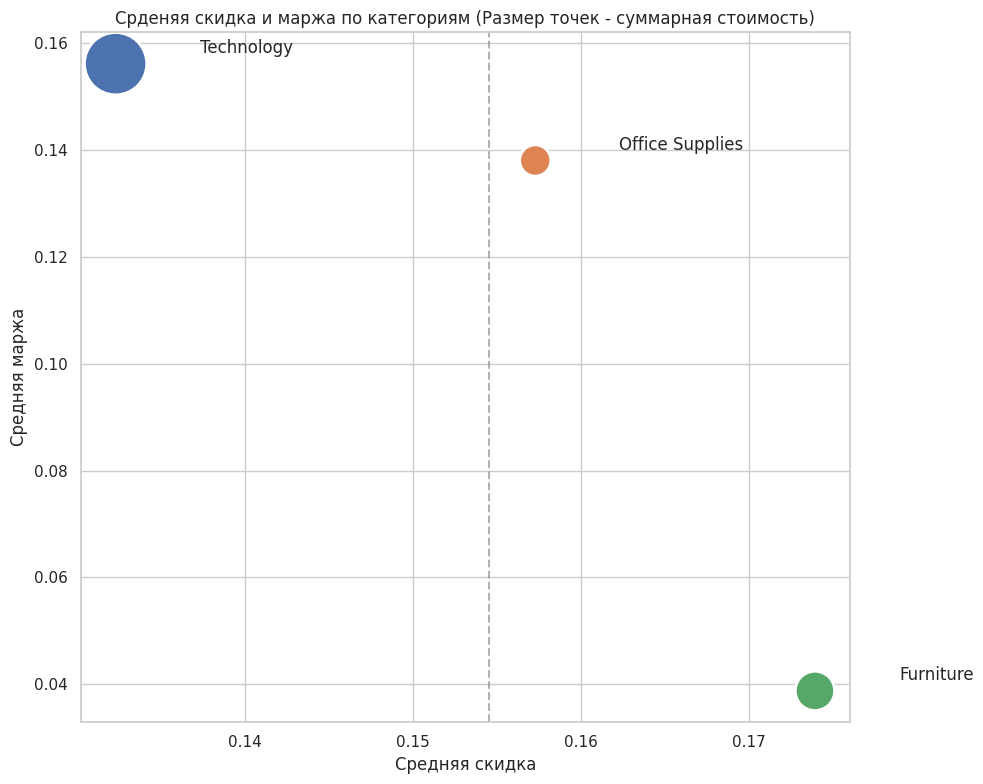

In [115]:
# Scatter: средняя скидка vs средняя маржа по категориям
plt.figure(figsize=(10,8))
kpi_cat_labeled = kpi_cat.reset_index()

sns.scatterplot(data=kpi_cat_labeled, x='mean_discount', y='mean_margin', size='total_sales', sizes=(500,2000), hue='Category', legend=False)

for i in range(len(kpi_cat_labeled)):
    plt.text(kpi_cat_labeled.iloc[i]['mean_discount'] + 0.005, kpi_cat_labeled.iloc[i]['mean_margin'] + 0.002, kpi_cat_labeled.iloc[i]['Category'], fontsize=12)

plt.axvline(kpi_cat_labeled['mean_discount'].mean(), color='grey', linestyle='--', alpha=0.6)
plt.title('Срденяя скидка и маржа по категориям (Размер точек - суммарная стоимость)')
plt.xlabel('Средняя скидка')
plt.ylabel('Средняя маржа')
plt.tight_layout()
plt.savefig('images/discount_vs_margin_by_category.png', dpi=200)
plt.show()

In [116]:
kpi_by_segment = df.groupby('Segment').agg(
    mean_sales=('Sales','mean'),
    mean_profit=('Profit','mean'),
    mean_discount=('Discount','mean'),
    mean_aov=('AOV','mean'),
    mean_margin=('margin','mean')
).reset_index().sort_values('mean_profit', ascending=False)
display(kpi_by_segment.head())

,Segment,mean_sales,mean_profit,mean_discount,mean_aov,mean_margin
2,Home Office,240.972041,33.818664,0.147128,64.005521,0.142870
1,Corporate,233.823300,30.456667,0.158228,61.480420,0.121203
0,Consumer,223.733644,25.836873,0.158141,59.533320,0.112050



**KPI-аналитика (AOV, маржа, скидка):**
- Категория `Technology` имеет самый высокий средний чек (AOV) и маржинальность.
- Категория `Furniture` имеет самую низкую среднюю маржинальность при самой высокой средней скидке, что может свидетельствовать о проблемах с прибыльностью при предоставлении скидок в этой категории.
- Наблюдается обратная зависимость между средней скидкой и средней маржой по категориям, что подтверждает ожидаемое влияние скидок на прибыльность.
- Среди сегментов самым прибыльным и с самой выскокой маржинальностью является `Home Office`, благодаря наивысшей средней стоимости и самым низким скидкам в сегментах.

# 7) RFM-анализ и визуализация

Проведем RFM-анализ

In [117]:
# Расчёт RFM
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('Customer ID').agg(
    Recency = ('Order Date', lambda x: (snapshot_date - x.max()).days),
    Frequency = ('Order ID', 'nunique'),
    Monetary = ('Sales', 'sum')
).reset_index()
rfm.to_csv('results/rfm_base.csv', index=False)

RFM-скоринг и распределение

In [118]:
# R, F, M квартильные скоринги (1..4)
rfm['R_quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F_quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

In [119]:
# RFM счет
rfm['RFM_Score'] = rfm['R_quartile'].astype(str) + rfm['F_quartile'].astype(str) + rfm['M_quartile'].astype(str)
rfm['RFM_Score_num'] = rfm['R_quartile'] + rfm['F_quartile'] + rfm['M_quartile']

In [120]:
# Сколько клиентов в каждом RFM score
rfm_count = rfm['RFM_Score'].value_counts().reset_index().rename(columns={'index':'RFM','RFM_Score':'count'})
display(rfm.head())
display(rfm_count.head())
display(rfm.describe().T)

,Customer ID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Score,RFM_Score_num
0,AA-10315,185,5,5563.560,1,1,4,114,6
1,AA-10375,20,9,1056.390,4,4,1,441,9
2,AA-10480,260,4,1790.512,1,1,2,112,4
3,AA-10645,56,6,5086.935,3,2,4,324,9
4,AB-10015,416,3,886.156,1,1,1,111,3


,count,count
0,111,55
1,444,34
2,112,26
3,344,24
4,443,24


,count,mean,std,min,25%,50%,75%,max
Recency,793.0,147.802018,186.211051,1.000,31.00,76.000,184.000,1166.00
Frequency,793.0,6.316520,2.550885,1.000,5.00,6.000,8.000,17.00
Monetary,793.0,2896.848500,2628.670117,4.833,1146.05,2256.394,3785.276,25043.05
R_quartile,793.0,2.509458,1.121518,1.000,2.00,3.000,4.000,4.00
F_quartile,793.0,2.498108,1.119302,1.000,1.00,2.000,3.000,4.00
M_quartile,793.0,2.498108,1.119302,1.000,1.00,2.000,3.000,4.00
RFM_Score_num,793.0,7.505675,2.501067,3.000,6.00,8.000,9.000,12.00


Распеределение клиентов по суммарному RFM

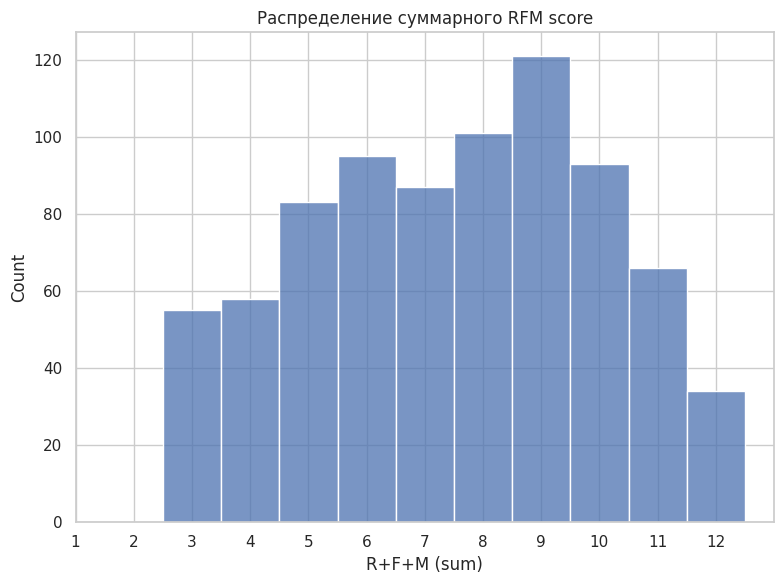

In [121]:
# Визуализация распределения RFM score
plt.figure()
sns.histplot(rfm['RFM_Score_num'], bins=12, kde=False, binwidth=1, discrete=True)
plt.title('Распределение суммарного RFM score')
plt.xlabel('R+F+M (sum)')
plt.tight_layout()
plt.savefig('images/rfm_score_distribution.png', dpi=200)
plt.xticks(range(1,13))
plt.show()

Топ-сегменты RFM: описание и выручка

In [122]:
# Топ сегменты по Monetary
rfm_profit = df.groupby('Customer ID').agg(
    total_profit=('Profit', 'sum'),
    mean_profit=('Profit', 'mean'),
    total_sales=('Sales', 'sum'),
    mean_sales=('Sales', 'mean')
).reset_index()

rfm_summary = rfm.merge(rfm_profit, on='Customer ID')

rfm_summary = rfm_summary.groupby('RFM_Score').agg(
    customers=('Customer ID','count'),
    avg_recency=('Recency','mean'),
    avg_frequency=('Frequency','mean'),
    avg_monetary=('Monetary','mean'),
    total_profit=('total_profit','sum'),
    mean_profit=('mean_profit','mean'),
    total_sales=('total_sales','sum'),
    mean_sales=('mean_sales','mean')
).reset_index().sort_values('customers', ascending=False)

display(rfm_summary.head(10))
rfm_summary.to_csv('results/rfm_summary.csv', index=False)

,RFM_Score,customers,avg_recency,avg_frequency,avg_monetary,total_profit,mean_profit,total_sales,mean_sales
0,111,55,490.581818,2.836364,500.256067,232.8931,2.278867,27514.0837,95.608489
60,444,34,16.000000,10.088235,5863.647053,27244.0701,42.893026,199363.9998,294.241442
1,112,26,482.692308,3.192308,1617.690492,2086.1475,2.509312,42059.9528,292.126186
45,344,24,49.000000,10.083333,6603.377479,21781.8240,43.433094,158481.0595,302.532121
59,443,24,17.833333,9.833333,2847.372642,3390.1148,5.569301,68336.9434,147.209891
31,311,23,57.826087,3.260870,628.921000,1632.8069,16.630342,14465.1830,143.166348
25,233,21,110.523810,6.952381,3075.717657,4373.0576,16.191156,64590.0708,235.866997
44,343,21,47.952381,9.809524,3079.846390,4105.2194,11.186822,64676.7742,174.242165
41,333,21,54.761905,7.095238,2834.876190,4800.9558,17.532775,59532.4000,213.409522
19,221,20,118.200000,5.350000,712.872150,1774.4441,11.213549,14257.4430,83.569761


**Выводы по RFM-анализу с учетом прибыли**

На основе таблицы `rfm_summary`, которая включает показатели прибыли для каждого RFM сегмента, можно сделать следующие выводы:

- **VIP-клиенты (RFM Score 444):** Этот сегмент (Recency: 16 дней, Frequency: ~10, Monetary: ~5863) демонстрирует самую высокую **общую прибыль (27244)** и самую высокую **среднюю прибыль (42.89)** на клиента среди всех сегментов. Это подтверждает, что клиенты, которые недавно и часто покупают, тратя при этом значительные суммы, являются наиболее прибыльными.
- **Сегменты с высокой Monetary и Frequency:** Другие сегменты с высокими показателями Frequency и Monetary (например, 344) также показывают высокую среднюю и общую прибыль. Это логично, так как эти клиенты совершают много покупок на значительные суммы.
- **Сегмент 111 (Низкие R, F, M):** Этот сегмент (Recency: 490 дней, Frequency: 2.8, Monetary: 500) имеет наибольшее количество клиентов (55), но при этом самую низкую **среднюю прибыль (2.28)**. Это "спящие" клиенты, которые давно не покупали, редко покупают и тратят мало, что приводит к очень низкой прибыльности.
- **Влияние Recency:** Сегменты с низким Recency (т.е. клиенты, которые недавно совершали покупки, например, 4xx) в целом показывают более высокую среднюю прибыль по сравнению с сегментами с высоким Recency (т.е. "старые" клиенты, например, 1xx), даже при сопоставимых Frequency и Monetary. Это подчеркивает важность недавности покупки для прибыльности.
- **Влияние Frequency и Monetary:** Высокие значения Frequency и Monetary обычно ассоциируются с более высокой средней прибылью, особенно в сочетании с низким Recency (например, 444).

**Общий вывод:**

RFM-сегментация, дополненная анализом прибыли, четко выделяет наиболее ценные и прибыльные сегменты клиентов (особенно VIP-сегмент 444). Клиенты, которые покупают недавно, часто и на большие суммы, приносят наибольшую прибыль. Сегменты с низкими показателями RFM имеют низкую прибыльность. Эти выводы подтверждают важность удержания и развития отношений с высокоприбыльными сегментами и могут служить основой для разработки целенаправленных маркетинговых стратегий.

# 8) Полный A/B-тест по скидкам

A/B-тест (`Discount`)

**Метрика:** `Profit` (прибыль) на заказ (строка в таблице соответствует заказу)

**Гипотезы:**
- H0 (нулевая): средняя прибыль заказов со скидкой равна средней прибыли заказов без скидки.
- H1 (альтернативная): средние прибыли различаются (двусторонняя). Можно рассматривать одностороннюю H1: "скидки уменьшают прибыль".

**Экспериментальная логика:**
- Группа A = заказы без скидки (`discount_flag = 0`) — контроль.
- Группа B = заказы со скидкой (`discount_flag = 1`) — эксперимент.
- Также рассматриваем уровни скидок (Low/Medium/High) — многоуровневый анализ.

Проверка размеров выборок и базовая агрегация

In [123]:
# Размеры групп A/B
n_no = df[df['discount_flag']==0].shape[0]
n_yes = df[df['discount_flag']==1].shape[0]
print(f'Нет скидки: {n_no}, есть скидка: {n_yes}')

Нет скидки: 4798, есть скидка: 5196


In [124]:
# Агрегация по группам скидок
ab_agg = df.groupby('discount_flag').agg(
    orders=('Row ID','count'),
    mean_profit=('Profit','mean'),
    median_profit=('Profit','median'),
    mean_sales=('Sales','mean'),
    mean_AOV=('AOV','mean')
).reset_index()
display(ab_agg)
ab_agg.to_csv('results/ab_agg.csv', index=False)

,discount_flag,orders,mean_profit,median_profit,mean_sales,mean_AOV
0,0,4798,66.900292,15.9952,226.742074,58.905042
1,1,5196,-6.657156,3.3408,232.735256,62.779789


Визуализация: profit по группам скидок

/tmp/ipython-input-518617343.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ab_agg, x='discount_flag', y='mean_profit', palette='mako')


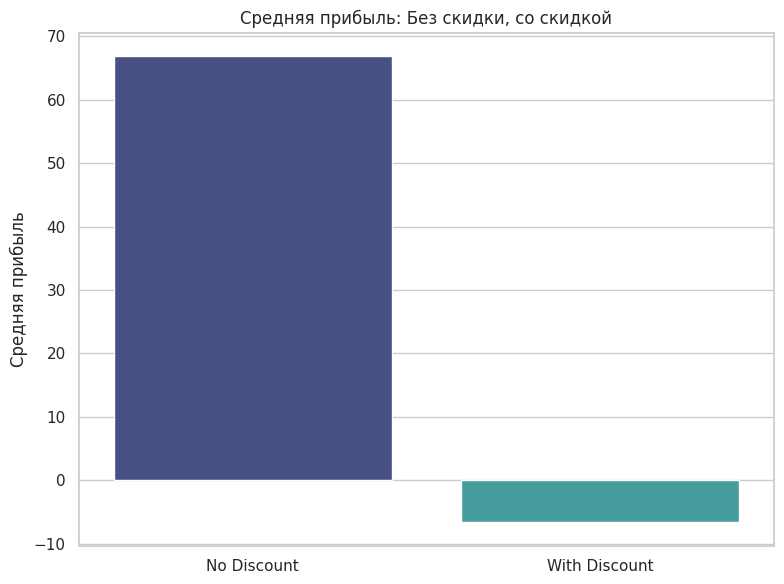

In [125]:
# Средняя прибыль по группам
plt.figure()
sns.barplot(data=ab_agg, x='discount_flag', y='mean_profit', palette='mako')
plt.xticks([0, 1], ['No Discount', 'With Discount']) # Added descriptive labels
plt.title('Средняя прибыль: Без скидки, со скидкой')
plt.ylabel('Средняя прибыль')
plt.xlabel('')
plt.tight_layout()
plt.savefig('images/mean_profit_no_vs_yes.png', dpi=200)
plt.show()

Заказы без скидок показываюь наибольшую среднюю прибыль, при этом товары сос кидкой в среднем приносят убытки

/tmp/ipython-input-611899954.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='discount_flag', y='Profit', palette='coolwarm')


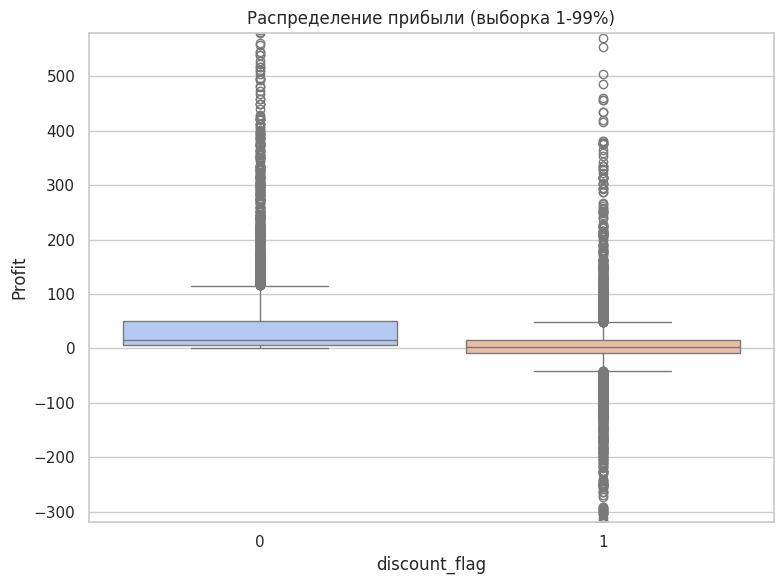

In [126]:
# Boxplot profit (выборка 1-99%)
p1 = df['Profit'].quantile(0.01)
p99 = df['Profit'].quantile(0.99)
plt.figure()
sns.boxplot(data=df, x='discount_flag', y='Profit', palette='coolwarm')
plt.ylim(p1, p99)
plt.title('Распределение прибыли (выборка 1-99%)')
plt.tight_layout()
plt.savefig('images/profit_boxplot_no_vs_yes.png', dpi=200)
plt.show()

Медиана прибыли для заказов без скидки значительно выше, чем для заказов со скидкой. Это подтверждает, что в среднем заказы без скидки приносят больше прибыли.

Диапазон прибыли для заказов без скидки шире и смещен в сторону положительных значений по сравнению с заказами со скидкой.

У заказов со скидкой наблюдается больше выбросов в сторону отрицательной прибыли, что указывает на значительные убытки по некоторым заказам со скидкой.

Статистические тесты: Welch t-test и Mann-Whitney

In [127]:
# Создаем выборки
a = df[df['discount_flag']==0]['Profit'].dropna()
b = df[df['discount_flag']==1]['Profit'].dropna()

Проведем тест Шапиро-Уилка на нормальность выборок

In [128]:
# Тест Шапиро-Уилка
shapiro_a_stat, shapiro_a_pval = shapiro(a)
shapiro_b_stat, shapiro_b_pval = shapiro(b)
print(f'Тест Шапиро-Уилка для группы без скидки (a): Statistic={shapiro_a_stat:.4f}, p-value={shapiro_a_pval:.6f}')
print(f'Тест Шапиро-Уилка для группы со скидкой (b): Statistic={shapiro_b_stat:.4f}, p-value={shapiro_b_pval:.6f}')

Тест Шапиро-Уилка для группы без скидки (a): Statistic=0.1935, p-value=0.000000
Тест Шапиро-Уилка для группы со скидкой (b): Statistic=0.2880, p-value=0.000000


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5196.
  res = hypotest_fun_out(*samples, **kwds)


В обоих случаях полученные p-значения значительно меньше стандартного уровня значимости 0.05. Это означает, что распределение прибыли как в группе без скидки, так и в группе со скидкой не является нормальным.

Так как распределение не является нормальным и выборки имеют выбросы, используем тест Манна-Уитни.

In [129]:
# Mann-Whitney (непараметрический)
u_stat, p_mw = mannwhitneyu(a, b, alternative='two-sided')
print(f'Mann-Whitney: U={u_stat:.4f}, p={p_mw:.6f}')

Mann-Whitney: U=18663602.5000, p=0.000000


p-value значительно меньше 0.05. Это указывает на **статистически значимую разницу** в средней прибыли между заказами со скидкой и без скидки.

Bootstrap для доверительного интервала разницы средних

In [130]:
# Bootstrap разницы средних
def bootstrap_mean_diff(x, y, n_boot=5000, seed=RND):
    rng = np.random.RandomState(seed)
    diffs = []
    x = np.array(x); y = np.array(y)
    for i in range(n_boot):
        xs = rng.choice(x, size=len(x), replace=True)
        ys = rng.choice(y, size=len(y), replace=True)
        diffs.append(xs.mean() - ys.mean())
    diffs = np.array(diffs)
    return diffs

In [131]:
diffs = bootstrap_mean_diff(a, b, n_boot=3000)
mean_diff = diffs.mean()
ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
print(f'Bootstrap средняя разница (NoDisc - Disc) = {mean_diff:.2f}; 95% CI = [{ci_lower:.2f}, {ci_upper:.2f}]')

Bootstrap средняя разница (NoDisc - Disc) = 73.50; 95% CI = [64.64, 83.45]


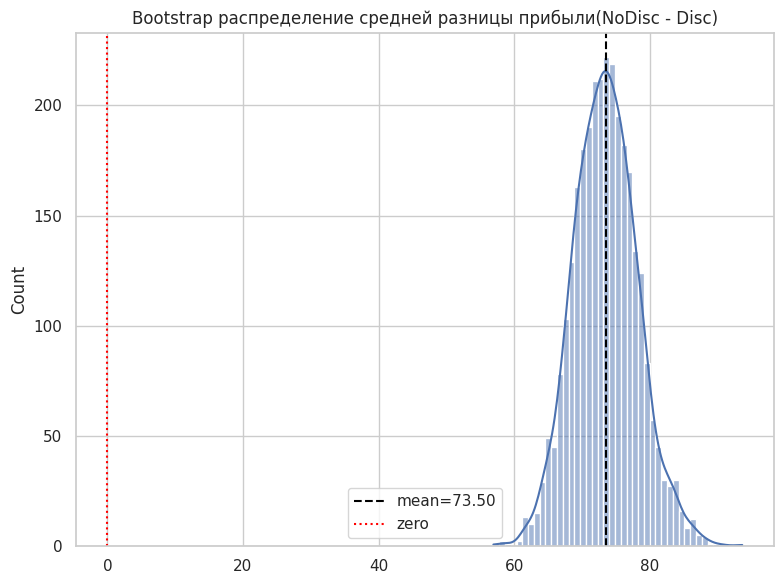

In [132]:
# Гистограмма bootstrap распределения
plt.figure()
sns.histplot(diffs, kde=True)
plt.axvline(mean_diff, color='black', linestyle='--', label=f'mean={mean_diff:.2f}')
plt.axvline(0, color='red', linestyle=':', label='zero')
plt.title('Bootstrap распределение средней разницы прибыли(NoDisc - Disc)')
plt.legend()
plt.tight_layout()
plt.savefig('images/bootstrap_diff_distribution.png', dpi=200)
plt.show()

В данном случае, 95% доверительный интервал для разницы средних прибылей (Без Скидки - Со Скидкой) составляет примерно [64.64, 83.45]. Поскольку этот интервал не содержит нуля, мы можем быть достаточно уверены, что существует статистически значимая разница в средней прибыли между группами, и средняя прибыль заказов без скидки выше, чем у заказов со скидкой.

**Регрессия: контроль ковариат (Profit ~ discount + Sales + Quantity + Category + Region)**

In [133]:
# Линейная регрессия с фиктивными переменными для категорий и регионов
df_reg = df.copy()
df_reg['discount_flag'] = (df_reg['Discount'] > 0).astype(int)

In [134]:
formula = 'Profit ~ discount_flag + Sales + Quantity + C(Category) + C(Region)'
model = ols(formula, data=df_reg).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     443.6
Date:                Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:01:30   Log-Likelihood:                -67192.
No. Observations:                9994   AIC:                         1.344e+05
Df Residuals:                    9985   BIC:                         1.345e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [135]:
# Сохраним таблицу коэффициентов
coef_df = model.summary2().tables[1]
coef_df.to_csv('results/regression_coefficients.csv')
display(coef_df.head(20))

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,0.107976,7.326995,0.014737,9.882425e-01,-14.254413,14.470364
C(Category)[T.Office Supplies],45.676630,5.170472,8.834132,1.178592e-18,35.541463,55.811798
C(Category)[T.Technology],46.811957,6.420448,7.291073,3.308279e-13,34.226585,59.397330
C(Region)[T.East],-0.026431,5.663322,-0.004667,9.962763e-01,-11.127684,11.074822
C(Region)[T.South],-2.995849,6.541513,-0.457975,6.469804e-01,-15.818533,9.826834
C(Region)[T.West],2.773954,5.536577,0.501023,6.163658e-01,-8.078853,13.626761
discount_flag,-71.315930,4.093252,-17.422805,5.395811e-67,-79.339529,-63.292330
Sales,0.185825,0.003390,54.809097,0.000000e+00,0.179179,0.192471
Quantity,-3.608577,0.925384,-3.899547,9.700401e-05,-5.422515,-1.794638


Интерпретация: коэффициент при discount_flag — эффект скидки на Profit при учёте других факторов. Коэффициент при `discount_flag` в регрессионной модели равен **-71.3159** с p-value **p < 0.05**. Это статистически значимый результат, который указывает на то, что при прочих равных условиях (с учетом Sales, Quantity, Category и Region), наличие скидки (`discount_flag = 1`) в среднем **уменьшает** прибыль на **~71.32**.

Проверим есть ли статистически значимые отличия в прибыли в группах скидок

In [136]:
# Попарные тесты для групп скидок против группы без скидки
discount_groups = ['Low (0-16%)','Medium (16-32%)','High (32-64%)','Very High (>64%)']
no_discount_profit = df[df['discount_group']=='No Discount']['Profit'].dropna()

pairwise_tests = []
for group_name in discount_groups:
    group_profit = df[df['discount_group']==group_name]['Profit'].dropna()
    if len(group_profit) > 0:
        tstat, pval = ttest_ind(no_discount_profit, group_profit, equal_var=False, nan_policy='omit')
        pairwise_tests.append({
            'group_vs_no_discount': f'{group_name} vs No Discount',
            'mean_no_discount': no_discount_profit.mean(),
            'mean_group': group_profit.mean(),
            't_stat': tstat,
            'p_value': pval,
            'n_group': len(group_profit)
        })

pairwise_tests_df = pd.DataFrame(pairwise_tests)

# Коррекция p-значений (FDR)
pvals = pairwise_tests_df['p_value'].values
reject, pvals_corr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
pairwise_tests_df['p_value_adj'] = pvals_corr
pairwise_tests_df['reject_H0'] = reject

display(pairwise_tests_df.sort_values('p_value_adj'))

pairwise_tests_df.to_csv('results/pairwise_discount_group_tests.csv', index=False)

,group_vs_no_discount,mean_no_discount,mean_group,t_stat,p_value,n_group,p_value_adj,reject_H0
2,High (32-64%) vs No Discount,66.900292,-123.518396,12.999256,2.621788e-33,421,1.048715e-32,True
1,Medium (16-32%) vs No Discount,66.900292,19.835564,11.325961,1.761717e-29,3911,3.523433e-29,True
3,Very High (>64%) vs No Discount,66.900292,-98.348741,10.882650,7.722722e-26,718,1.029696e-25,True
0,Low (0-16%) vs No Discount,66.900292,71.562798,-0.456182,6.487742e-01,146,6.487742e-01,False


Группа 'Low (0-16%)' vs 'No Discount':

  - p_value_adj = 0.6488. Это значительно выше уровня значимости 0.05.

  - reject_H0 = False.

  - **Вывод:** Нет статистически значимой разницы в средней прибыли между заказами с низкой скидкой (0-16%) и заказами без скидки. Средняя прибыль в группе низкой скидки даже немного выше (71.56) по сравнению с группой без скидки (66.90), но эта разница не является статистически значимой при данном размере выборки для этой группы (N=146).
  
  - Во всех остальных группах есть статистичиски значимая разница в средней прибыли.

Применение средних, высоких и очень высоких скидок статистически значимо и негативно влияет на среднюю прибыль по сравнению с отсутствием скидки. Низкие скидки (0-16%) не показывают статистически значимого отличия от группы без скидки по средней прибыли, хотя среднее значение прибыли там даже немного выше. Это может говорить о том, что умеренные скидки не приводят к значительной потере прибыли, в отличие от более высоких скидок.

Power-анализ: необходимый размер выборки

In [137]:
power = TTestIndPower()
# Пример: хотим обнаружить средний эффект d=0.3 с power=0.8 alpha=0.05
d = 0.3
required_n = power.solve_power(effect_size=d, power=0.8, alpha=0.05, ratio=1)
print(f'Нужен N на каждую группу ≈ {np.ceil(required_n)} для обнаружения эффекта d={d}')

Нужен N на каждую группу ≈ 176.0 для обнаружения эффекта d=0.3


In [138]:
# Также посчитаем наблюдаемую мощность при текущих N и предполагаемом эффекте
n_current = min(n_no, n_yes)
observed_power = power.power(effect_size=d, nobs1=n_current, alpha=0.05, ratio=1)
print(f'При текущем N (каждая группа ~{n_current}) мощность для d={d} ≈ {observed_power:.3f}')

При текущем N (каждая группа ~4798) мощность для d=0.3 ≈ nan


Выборки имеют достаточный разммер

**Выводы по разделу Полный A/B-тест по скидкам**

На основе проведенного полного A/B-теста по влиянию скидок (`Discount`) на прибыль (`Profit`) были получены следующие ключевые результаты:

1.  **Базовое сравнение (Без скидки vs Со скидкой):**
    - Визуальный анализ (barplot и boxplot) показал, что средняя и медианная прибыль заказов без скидки значительно выше, чем у заказов со скидкой. Заказы со скидкой в среднем приносят убытки.
    - Статистический тест Mann-Whitney U test подтвердил наличие статистически значимой разницы в прибыли между группами со скидкой и без скидки.
    - Bootstrap анализ разницы средних показал, что 95% доверительный интервал для разницы (Прибыль Без Скидки - Прибыль Со Скидкой) не содержит нуля, что еще раз подтверждает статистически значимое превосходство прибыли в группе без скидки.

2.  **Регрессионный анализ с контролем ковариат:**
    - Линейная регрессия (Profit ~ discount_flag + Sales + Quantity + C(Category) + C(Region)) показала, что при прочих равных условиях (с учетом влияния продаж, количества, категории и региона), наличие скидки (discount_flag = 1) статистически значимо уменьшает ожидаемую прибыль на **~71.32** (коэффициент при discount_flag = -71.3159, p < 0.05). Это подтверждает негативное влияние скидки на прибыль даже при наличии других факторов.

3.  **Анализ по группам скидок:**
    - Низкие скидки (0-16%) **не имеют статистически значимого отличия** по средней прибыли от заказов без скидки.
    - Средние (16-32%), высокие (32-64%) и очень высокие (>64%) скидки статистически значимо снижают среднюю прибыль по сравнению с заказами без скидки. При этом высокие и очень высокие скидки приводят к значительным средним убыткам на заказ.

4.  **Power-анализ:**
    - Текущий размер выборки в данных (около 4800 наблюдений на группу) более чем достаточен для обнаружения даже малых/средних эффектов (d=0.3) с высокой статистической мощностью. Это повышает уверенность в надежности полученных результатов.

**Общий вывод:**

Проведение скидок, особенно на уровнях выше 16%, статистически значимо и негативно влияет на прибыль. Низкие скидки (0-16%) не показывают статистически значимого негативного эффекта на прибыль по сравнению с отсутствием скидки.

Эти результаты подтверждают альтернативную гипотезу о том, что средние прибыли заказов со скидкой и без скидки различаются, и, более конкретно, что скидки (за исключением, очень низких) приводят к снижению прибыли.

# 9) Общие выводы по проекту и бизнес-рекомендации

На основе проведенного анализа продаж, RFM-сегментации и A/B-тестирования влияния скидок, были получены следующие ключевые выводы и рекомендации:

1.  **Маркетинговый анализ:**
    - Наибольшую прибыль приносят категории **Technology** и **Office Supplies**. Категория **Furniture** значительно отстает по прибыльности, несмотря на высокий объем продаж, что частично связано с высокими скидками в этой категории.
    - Топ-продукты по прибыли — это в основном дорогостоящие товары из категории Technology
    - Основные центры прибыли находятся в штатах **Калифорния** и **Нью-Йорк**, а также в **Западном** и **Восточном** регионах. Города Нью-Йорк, Лос-Анджелес и Сиэтл являются ключевыми точками.
    - Наблюдаются региональные различия в среднем чеке (AOV) и маржинальности.

2.  **Сезонность:**
    - Выявлена сильная **сезонность** с пиками продаж и прибыли в **ноябре и декабре**, что совпадает с периодом праздничных распродаж.
    - Присутствует общий **восходящий тренд** в продажах и прибыли на протяжении всего периода данных.
    - Анализ по дням недели показал вариативность в количестве заказов и средней прибыли/продажах.

3.  **RFM-анализ:**
    - Клиентская база успешно сегментирована по новизне, частоте и денежной стоимости покупок.
    - Сегмент **(444)**, хотя и составляет небольшую долю клиентов, вносит наибольший вклад в общую выручку и прибыль.
    - Выделены другие важные сегменты, такие как Активные, Под угрозой оттока, Новые и Спящие клиенты, каждый из которых требует специфического подхода.

4.  **A/B-тест скидок:**
    - Скидки, особенно на уровнях **выше 16% (Medium, High, Very High)**, статистически значимо и негативно влияют на прибыль, приводя к существенному ее снижению или даже убыткам на заказ по сравнению с заказами без скидки.
    - **Низкие скидки (0-16%)** не показали статистически значимого отличия по средней прибыли от группы без скидки.
    - Регрессионный анализ подтвердил, что наличие скидки при прочих равных условиях значительно уменьшает ожидаемую прибыль (~на 71.32).
    - Текущий размер выборки достаточен для обнаружения даже малых эффектов с высокой мощностью.

**Бизнес-рекомендации:**

1.  **Стратегия ценообразования и скидок:**
    - **Пересмотреть политику скидок:** Избегать высоких скидок (>16%).
    - **Тестировать низкие скидки:** Продолжить эксперименты с низкими уровнями скидок (например, 5-15%), поскольку они не показали статистически значимого негативного эффекта на прибыль и потенциально могут стимулировать объем продаж без существенных потерь маржи.
    - **Дифференцировать скидки:** Применять скидки более точечно, возможно, на немаржинальные товары для стимулирования трафика или в рамках пакетов с высокомаржинальными товарами.

2.  **Управление клиентами (CRM) на основе RFM:**
    - **Удержание VIP-клиентов:** Разработать эксклюзивные программы лояльности, персональные предложения и коммуникации для сегмента 444.
    - **Реактивация клиентов под угрозой оттока:** Использовать персонализированные кампании со специальными предложениями для клиентов с низким Recency, но высокими Frequency и Monetary в прошлом.
    - **Стимулирование новых клиентов:** Предлагать бонусы или небольшие скидки на вторую покупку для клиентов с высоким Recency и низкими Frequency/Monetary, чтобы стимулировать их к повторным заказам.
    - **Оптимизация работы со "Спящими" клиентами:** Оценить стоимость реактивации по сравнению с потенциальной прибылью. Возможно, стоит сосредоточить маркетинговые усилия на более перспективных сегментах.

3.  **Оптимизация ассортимента и географии:**
    - **Фокус на прибыльных категориях/продуктах:** Активно продвигать товары из категорий Technology и Office Supplies, а также конкретные высокоприбыльные продукты.
    - **Анализ категории Furniture:** Детально исследовать причины низкой маржинальности мебели и высокого уровня скидок.
    - **Развитие ключевых регионов и городов:** Инвестировать в маркетинг и логистику в Западном и Восточном регионах, особенно в Нью-Йорке, Лос-Анджелесе и Сиэтле.

Эти выводы и рекомендации могут служить основой для принятия стратегических решений, направленных на повышение общей прибыльности бизнеса.

> Полный отчёт, таблицы и графики находятся в папке `results/` и `images/`.